In [1]:
import os
import sys
import glob
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.time import Time

import casatools as tools

import logging
log = logging.getLogger(__name__)
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

In [2]:
from orca.proj import boilerplate
from orca.transform import imaging, peeling, dada2ms
from orca.metadata.pathsmanagers import OfflinePathsManager
from orca.flagging import merge_flags
from orca.utils import fitsutils

In [3]:
import warnings
warnings.simplefilter('ignore')  # silence noisey astropy display of fits image

In [4]:
# Ultimate goal is to use celery to schedule jobs and their dependencies

#boilerplate.run_dada2ms.s(dada_file=pm.get_dada_path(spw, time), out_ms=msfile, gaintable=pm.get_gaintable_path(spw))()

# and

#from orca.proj.celery import app
#from celery import chain
#chain(make_image.partial(**other_params), flag_chans, peel, dada2ms.s(pm.something())).()

In [5]:
def showfits(fitsfile):
    """ Read fitsfile and display it
    """
    
    image, header = fitsutils.read_image_fits(fitsfile)
    wcs = WCS(header, naxis=2)
    lst = getLST(header)
    
    print("Showing image {0} at LST {1:.2f} (full range {2:.2f} to {3:.2f} Jy/beam)"
          .format(fitsfile.split('/')[-1], lst, image.min(), image.max()))
    
#    fig, ax = plt.subplots(figsize=(15,15), subplot_kw={'projection': wcs})
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111, projection=wcs)
    ax.grid(b=True, linewidth=1, color='r')
    xticklocations = np.arange(-np.pi+30.*(np.pi/180.), np.pi, 30.*(np.pi/180.))
    xticklabels = [r"{0:d}".format(ang) for ang in np.arange(330,0,-30)]
    ax.set_xticks(xticklocations)
    ax.set_xticklabels(xticklabels)

    scale = np.abs(image.min())
    im = ax.imshow(image, vmin=-scale/2, vmax=2*scale, cmap='Greys')
    cb = fig.colorbar(im)


def getLST(header):
    """ Low-precision LST at OVRO-LWA
    """

    # Create astropy time object
    utcTime = header['DATE-OBS']
    time = Time(utcTime, scale='utc', location=('-118.3d','37.23d'))
    time.delta_ut1_utc = 0.  # force low precision

    return time.sidereal_time('mean').hour

In [6]:
buffer = 'current'  # choose a buffer
outdir = '/lustre/claw/'
pm = OfflinePathsManager(utc_times_txt_path='/lustre/data/{0}/utc_times.txt'.format(buffer), 
                         dadafile_dir='/lustre/data/{0}'.format(buffer), 
                         msfile_dir=outdir,
                         bcal_dir='/lustre/mmanders/bufferdata/hourly/BCAL_stripe3',
                         flag_npy_path='/home/yuping/100-hr-a-priori-flags/20191125-consolidated-flags/20191125-consolidated-flags.npy')

In [12]:
# parameters for data

age = 1 # hours
duration = 13 # seconds
spws = ['15']  # 

In [13]:
now = datetime.now()
start_time = now.replace(hour=now.hour-age)
end_time = start_time + timedelta(seconds=duration)

t_start = Time(start_time, format='datetime')
t_start.delta_ut1_utc = 0.  # force low precision
lst_start = t_start.sidereal_time('mean', '-118.3d').hour
print("Start time LST is {0:.2f} hours".format(lst_start))

Start time LST is 13.73 hours


In [14]:
for time in pm.utc_times_mapping: 
    if start_time <= time < end_time:
        msfiles = []  # all spw per time
        for spw in spws:
            msfile = pm.get_ms_path(time, spw)
            print("Converting to MS for time {0}, spw {1} with name {2}".format(time, spw, msfile))
            _ = dada2ms.run_dada2ms(dada_file=pm.get_dada_path(spw, time), out_ms=msfile,
                                    gaintable=pm.get_gaintable_path(spw)) 
            merge_flags.write_to_flag_column(msfile, pm.get_flag_npy_path(None))
            if (lst_start > 13) or (lst_start < 8):
                print("LST is {0}. Peeling 17h < LST < 3h".format(lst_start))
                peeling.peel_with_ttcal(msfile, '/home/claw/code/calim-pipeline-phase2/sources.json') 
            msfiles.append(msfile)

        fitsdir = '/'.join(msfile.split('/')[:-1])
        imaging.make_image(msfiles, date_times_string=start_time.strftime("%Y-%m-%d"),
                           out_dir=fitsdir)

Converting to MS for time 2019-12-12 16:12:51, spw 15 with name /lustre/claw//2019-12-12/hh=16/2019-12-12T16:12:51/15_2019-12-12T16:12:51.ms
Successful read/write open of default-locked table /lustre/claw//2019-12-12/hh=16/2019-12-12T16:12:51/15_2019-12-12T16:12:51.ms: 22 columns, 32896 rows
LST is {0}. Peeling 17h < LST < 3h


## Image check

Showing image 2019-12-12-image.fits at LST 13.73 (full range -151.25 to 984.94 Jy/beam)


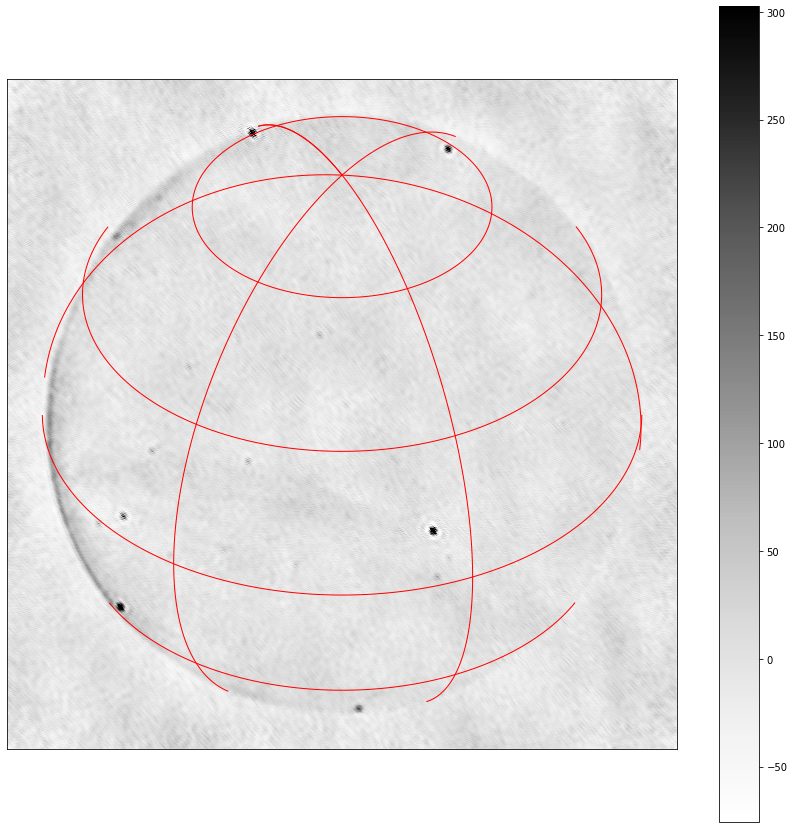

In [15]:
fitsfile = os.path.join(fitsdir, '2019-12-12-image.fits')
showfits(fitsfile)

Showing image 2019-12-12-image.fits at LST 12.56 (full range -287.41 to 1889.32 Jy/beam)
Showing image 2019-12-12-image.fits at LST 13.01 (full range -97.29 to 639.27 Jy/beam)
Showing image 2019-12-12-image.fits at LST 13.53 (full range -564.03 to 3697.71 Jy/beam)
Showing image 2019-12-12-image.fits at LST 13.66 (full range -565.54 to 3806.71 Jy/beam)
Showing image 2019-12-12-image.fits at LST 13.73 (full range -151.25 to 984.94 Jy/beam)


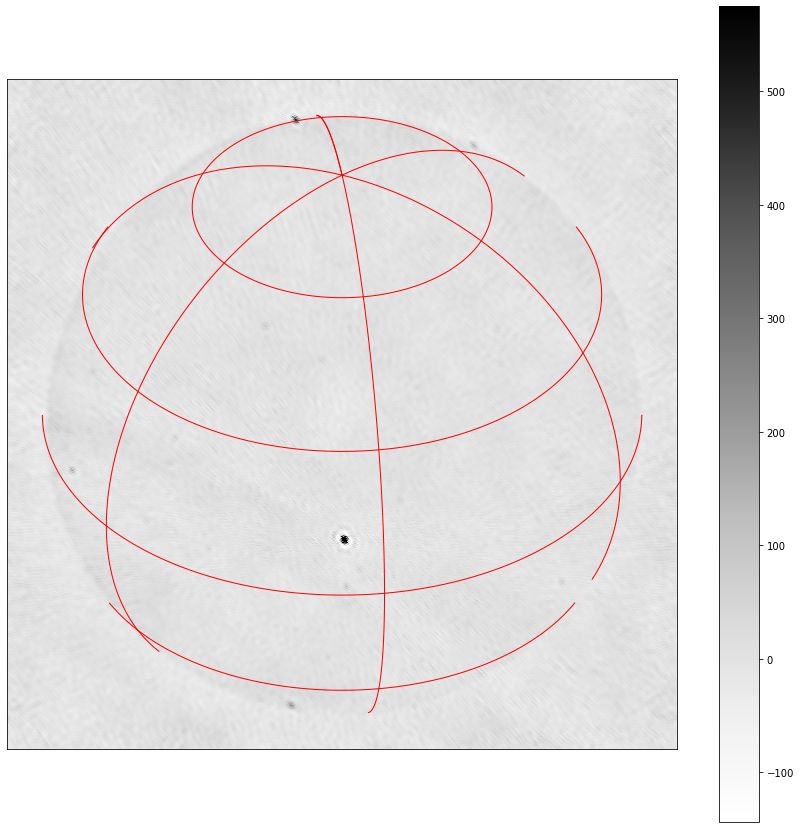

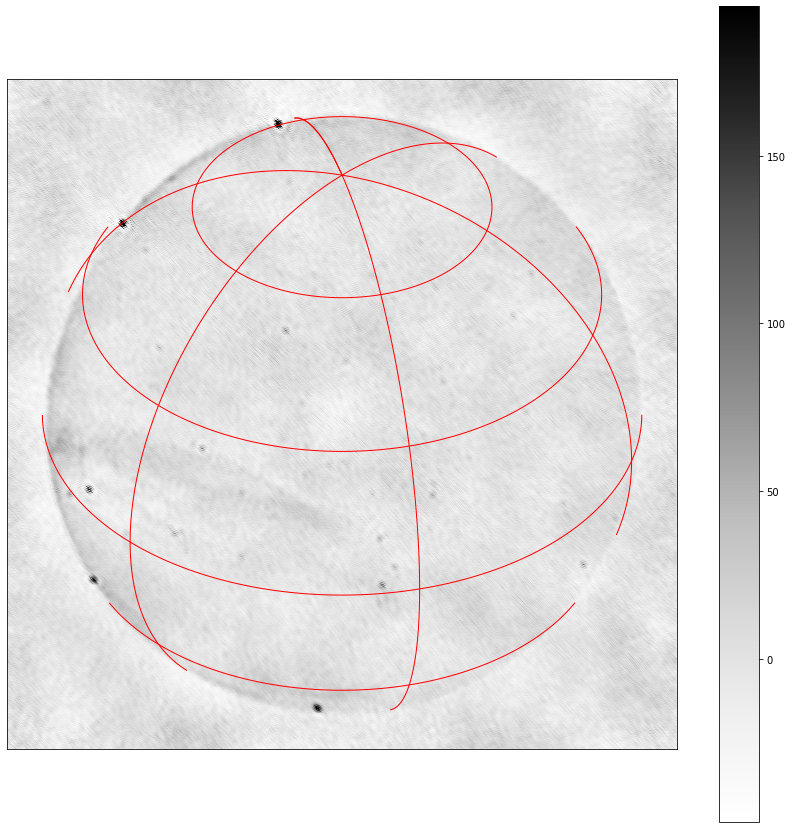

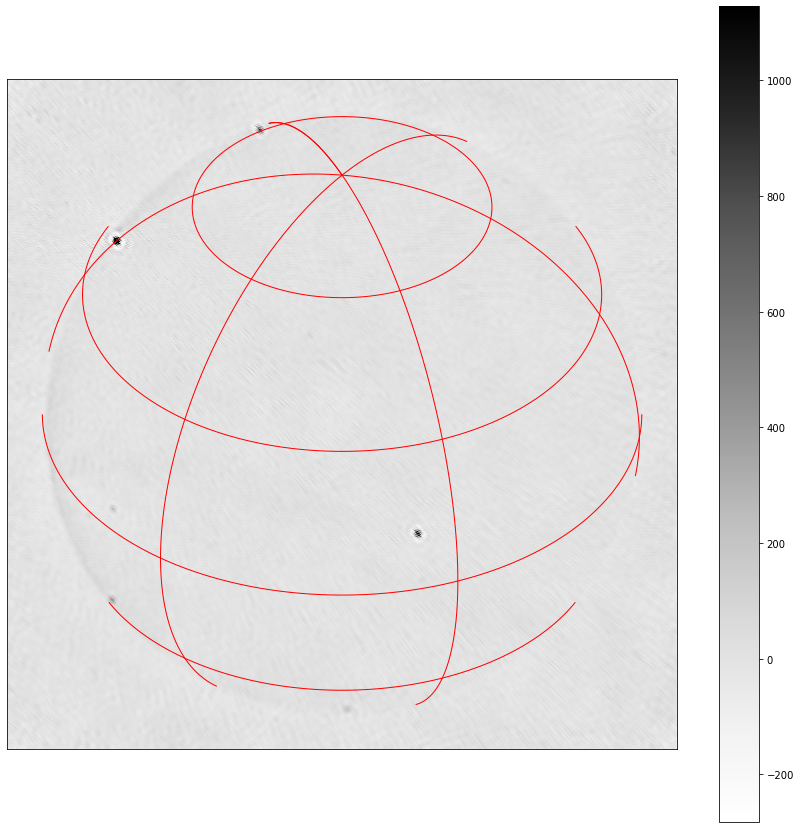

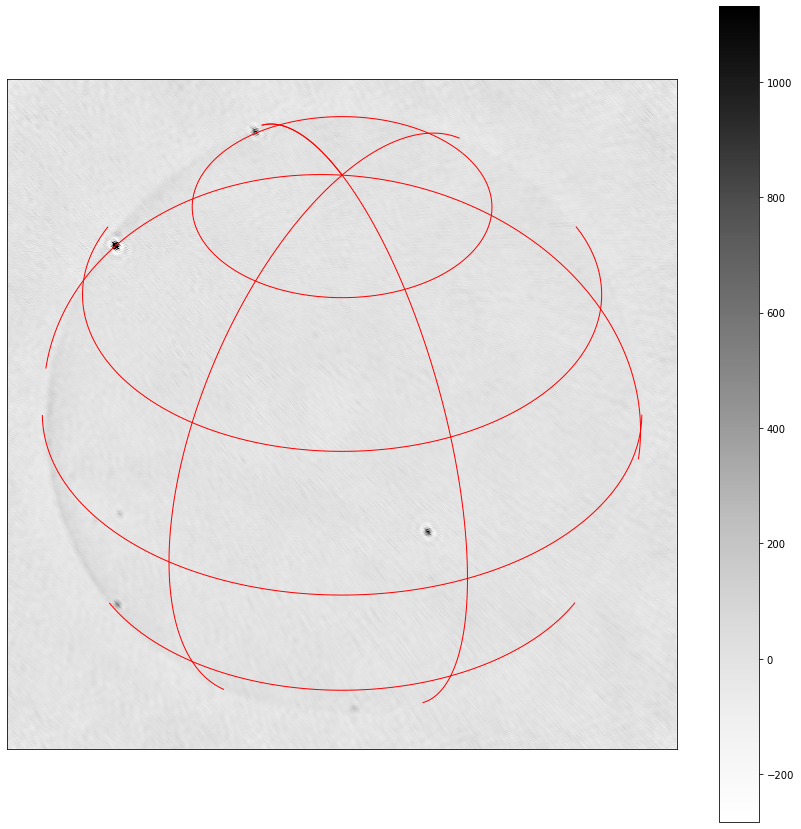

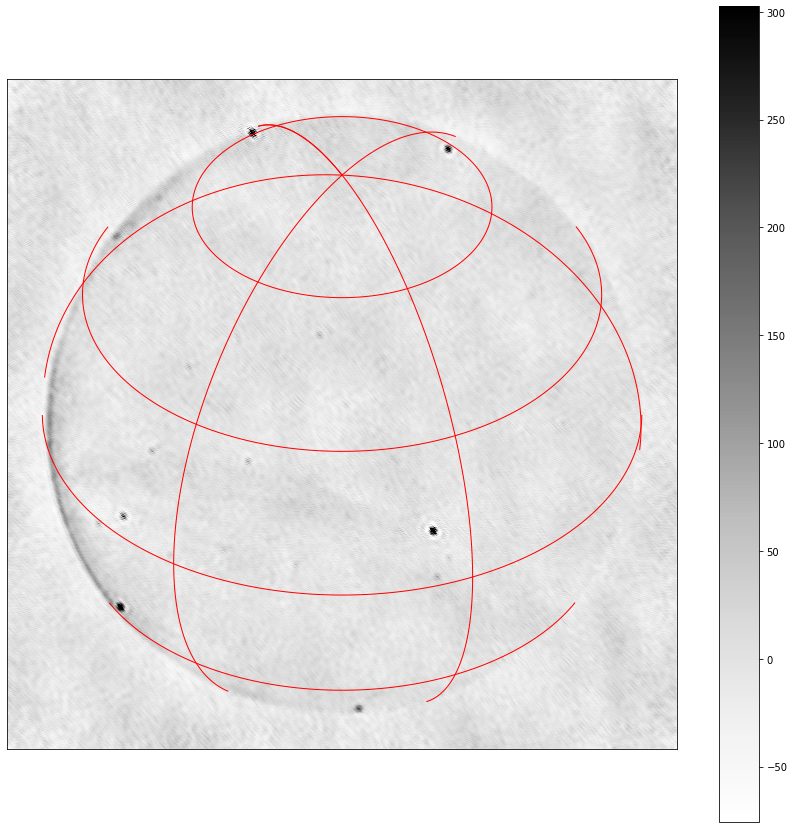

In [16]:
fitsfiles = sorted(glob.glob(outdir + '2019-12-12/*/*/*image.fits'))
for fitsfile in fitsfiles:
    showfits(fitsfile)

## Visibility data check

In [ ]:
ms = tools.ms()
ms.open(msfile)
ms.summary()
getdata = ms.getdata(['data', 'data_desc_id', 'axis_info'], ifraxis=True)
data = getdata['data']
npol, nchan, nbl = data.shape

In [ ]:
print(list(getdata['axis_info'].keys()))
ifr_name = getdata['axis_info']['ifr_axis']['ifr_name']
baseline = getdata['axis_info']['ifr_axis']['baseline']

In [ ]:
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(15,15))
sel = np.where(baseline > 10)[0]
ax0.plot(baseline[sel], np.abs(data[0,0,sel]), 'r,')
ax0.plot(baseline[sel], np.abs(data[3,0,sel]), 'b,')
_ = ax0.set_xlabel("UV distance")
_ = ax0.set_ylabel("Flux density")

ax1.plot(baseline[sel], np.abs(data[0,0,sel]), 'r,')
ax1.plot(baseline[sel], np.abs(data[3,0,sel]), 'b,')
ax1.set_ylim(0, 1e5)
_ = ax1.set_xlabel("UV distance")
_ = ax1.set_ylabel("Flux density")

In [ ]:
arr = np.zeros((256, 256), dtype=float)
data2 = data.mean(axis=0).mean(axis=0)
for i, ifr in enumerate(ifr_name):
    ant1n, ant2n = ifr.split('-')
    ant1 = int(ant1n.lstrip("ANT"))
    ant2 = int(ant2n.lstrip("ANT"))
    arr[ant1-1, ant2-1] = data2[i]

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
arr = np.ma.masked_equal(arr, 0)
ax.imshow(arr, origin='bottom', vmin=0, vmax=arr.max()/1e4, cmap='Greys')
_ = ax.set_xlabel("Ant1")
_ = ax.set_ylabel("Ant2")